In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

%matplotlib inline

Using TensorFlow backend.


In [2]:
LABELS = 10 # Number of different types of labels (1-10)
WIDTH = 28 # width / height of the image
CHANNELS = 1 # Number of colors in the image (greyscale)
VALID = 10000 # Validation data size

In [3]:
data = pd.read_csv('../data/digit-recognizer/train.csv')

In [4]:
data.shape

(42000, 785)

In [5]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Prepare data
    - Apply one hot encoding on labels
    - Convert the data into shape of (#rows, height, width, channels) shape
    - Normalize the input data (TODO)
    - Add dropout in model (TODO)

In [6]:
# def normalize_data(data):
#     return data/data.max()

# train_data_norm = normalize_data(train_data)

In [7]:
labels = np.array(data.pop('label'))
labels = LabelEncoder().fit_transform(labels)[:, None]
labels = OneHotEncoder().fit_transform(labels).todense()

In [8]:
data = StandardScaler().fit_transform(np.float32(data.values)) # Convert the dataframe to a numpy array
data = data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images
train_data, valid_data = data[:-VALID], data[-VALID:]
train_labels, valid_labels = labels[:-VALID], labels[-VALID:]

In [9]:
print(f'Train shape: {train_data.shape}')
print(f'Validation shape: {valid_data.shape}')

Train shape: (32000, 28, 28, 1)
Validation shape: (10000, 28, 28, 1)


### Model

2 Convoltutional Layers and 1 fully connected layer

In [10]:
def cnn_model(input_shape):
    '''
    Implement forward propogation for multi class classification problem:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> ReLU -> MAXPOOL -> FLATTEN -> DENSE -> SOFTMAX
    '''
    input_img = tf.keras.Input(shape=input_shape)
    z1 = tf.keras.layers.Conv2D(4,(14,14), strides=1, padding='same')(input_img)
    A1 = tf.keras.layers.ReLU()(z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size = (8,8), strides=4,  padding='same')(A1)
    z2 = tf.keras.layers.Conv2D(8, (7,7), strides=1, padding='same')(P1)
    A2 = tf.keras.layers.ReLU()(z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size = (4,4), strides=2,  padding='same')(A2)
    z3 = tf.keras.layers.Conv2D(16, (4,4), strides = 1, padding = 'same')(P2)
    A3 = tf.keras.layers.ReLU()(z3)
    P3 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=1,  padding='same')(A3)
    F = tf.keras.layers.Flatten()(P3)
    FC = tf.keras.layers.Dense(20, activation='relu')(F)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(FC)
    
    model = tf.keras.Model(inputs = input_img, outputs=outputs)
    return model

In [19]:
conv_model = cnn_model((28, 28,1))

In [20]:
conv_model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

conv_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 4)         788       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 28, 28, 4)         0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 8)           1576      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 7, 7, 8)           0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0   

## Train Model

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(64)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels)).batch(64)


In [22]:
%%time
history = conv_model.fit(train_dataset, epochs=500, validation_data=valid_dataset)

Train for 500 steps, validate for 157 steps
Epoch 1/500
500/500 [==============================] - 18s 37ms/step - loss: 0.7062 - accuracy: 0.7803 - val_loss: 0.3104 - val_accuracy: 0.9110
Epoch 2/500
500/500 [==============================] - 17s 35ms/step - loss: 0.2269 - accuracy: 0.9345 - val_loss: 0.1842 - val_accuracy: 0.9481
Epoch 3/500
500/500 [==============================] - 18s 36ms/step - loss: 0.1741 - accuracy: 0.9489 - val_loss: 0.1763 - val_accuracy: 0.9488
Epoch 4/500
500/500 [==============================] - 18s 35ms/step - loss: 0.1451 - accuracy: 0.9575 - val_loss: 0.1475 - val_accuracy: 0.9562
Epoch 5/500
500/500 [==============================] - 18s 36ms/step - loss: 0.1290 - accuracy: 0.9611 - val_loss: 0.1169 - val_accuracy: 0.9679
Epoch 6/500
500/500 [==============================] - 18s 35ms/step - loss: 0.1133 - accuracy: 0.9656 - val_loss: 0.1265 - val_accuracy: 0.9632
Epoch 7/500
500/500 [==============================] - 18s 35ms/step - loss: 0.1048 - 

Epoch 57/500
500/500 [==============================] - 17s 35ms/step - loss: 0.0358 - accuracy: 0.9884 - val_loss: 0.1416 - val_accuracy: 0.9726
Epoch 58/500
500/500 [==============================] - 18s 36ms/step - loss: 0.0251 - accuracy: 0.9912 - val_loss: 0.1535 - val_accuracy: 0.9725
Epoch 59/500
500/500 [==============================] - 7560s 15s/step - loss: 0.0267 - accuracy: 0.9908 - val_loss: 0.2069 - val_accuracy: 0.9679
Epoch 60/500
500/500 [==============================] - 18s 36ms/step - loss: 0.0364 - accuracy: 0.9884 - val_loss: 0.1921 - val_accuracy: 0.9675
Epoch 61/500
500/500 [==============================] - 18s 36ms/step - loss: 0.0350 - accuracy: 0.9881 - val_loss: 0.1723 - val_accuracy: 0.9702
Epoch 62/500
500/500 [==============================] - 18s 36ms/step - loss: 0.0446 - accuracy: 0.9864 - val_loss: 0.1719 - val_accuracy: 0.9685
Epoch 63/500
500/500 [==============================] - 18s 36ms/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.1571 

500/500 [==============================] - 20s 40ms/step - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.1965 - val_accuracy: 0.9721
Epoch 114/500
500/500 [==============================] - 20s 39ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.2420 - val_accuracy: 0.9669
Epoch 115/500
500/500 [==============================] - 19s 37ms/step - loss: 0.0261 - accuracy: 0.9926 - val_loss: 0.2249 - val_accuracy: 0.9718
Epoch 116/500
500/500 [==============================] - 18s 35ms/step - loss: 0.0222 - accuracy: 0.9930 - val_loss: 0.2290 - val_accuracy: 0.9701
Epoch 117/500
500/500 [==============================] - 17s 35ms/step - loss: 0.0192 - accuracy: 0.9933 - val_loss: 0.2163 - val_accuracy: 0.9695
Epoch 118/500
500/500 [==============================] - 18s 36ms/step - loss: 0.0105 - accuracy: 0.9962 - val_loss: 0.2296 - val_accuracy: 0.9724
Epoch 119/500
500/500 [==============================] - 18s 37ms/step - loss: 0.0290 - accuracy: 0.9911 - val_loss: 0.2705 - val_ac

Epoch 169/500
500/500 [==============================] - 19s 39ms/step - loss: 0.0312 - accuracy: 0.9915 - val_loss: 0.2505 - val_accuracy: 0.9692
Epoch 170/500
500/500 [==============================] - 21s 41ms/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.2273 - val_accuracy: 0.9757
Epoch 171/500
500/500 [==============================] - 21s 42ms/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 0.2205 - val_accuracy: 0.9725
Epoch 172/500
500/500 [==============================] - 22s 45ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.2780 - val_accuracy: 0.9697
Epoch 173/500
500/500 [==============================] - 24s 47ms/step - loss: 0.0172 - accuracy: 0.9953 - val_loss: 0.2280 - val_accuracy: 0.9740
Epoch 174/500
500/500 [==============================] - 22s 45ms/step - loss: 0.0148 - accuracy: 0.9955 - val_loss: 0.2593 - val_accuracy: 0.9729
Epoch 175/500
500/500 [==============================] - 21s 42ms/step - loss: 0.0094 - accuracy: 0.9966 - val_loss: 0

Epoch 225/500
500/500 [==============================] - 20s 40ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.3475 - val_accuracy: 0.9656
Epoch 226/500
500/500 [==============================] - 19s 37ms/step - loss: 0.0154 - accuracy: 0.9955 - val_loss: 0.2707 - val_accuracy: 0.9718
Epoch 227/500
500/500 [==============================] - 18s 37ms/step - loss: 0.0162 - accuracy: 0.9959 - val_loss: 0.2575 - val_accuracy: 0.9717
Epoch 228/500
500/500 [==============================] - 19s 38ms/step - loss: 0.0304 - accuracy: 0.9929 - val_loss: 0.2428 - val_accuracy: 0.9741
Epoch 229/500
500/500 [==============================] - 20s 41ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.2512 - val_accuracy: 0.9757
Epoch 230/500
500/500 [==============================] - 19s 39ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.2794 - val_accuracy: 0.9746
Epoch 231/500
500/500 [==============================] - 19s 38ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0

Epoch 281/500
500/500 [==============================] - 19s 37ms/step - loss: 0.0249 - accuracy: 0.9938 - val_loss: 0.2953 - val_accuracy: 0.9721
Epoch 282/500
500/500 [==============================] - 20s 39ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.2820 - val_accuracy: 0.9740
Epoch 283/500
500/500 [==============================] - 18s 37ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.3232 - val_accuracy: 0.9711
Epoch 284/500
500/500 [==============================] - 18s 37ms/step - loss: 0.0280 - accuracy: 0.9931 - val_loss: 0.2678 - val_accuracy: 0.9731
Epoch 285/500
500/500 [==============================] - 19s 37ms/step - loss: 0.0210 - accuracy: 0.9945 - val_loss: 0.2934 - val_accuracy: 0.9718
Epoch 286/500
500/500 [==============================] - 19s 38ms/step - loss: 0.0230 - accuracy: 0.9953 - val_loss: 0.4682 - val_accuracy: 0.9627
Epoch 287/500
500/500 [==============================] - 19s 38ms/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0

Epoch 337/500
500/500 [==============================] - 21s 42ms/step - loss: 0.0157 - accuracy: 0.9960 - val_loss: 0.3153 - val_accuracy: 0.9724
Epoch 338/500
500/500 [==============================] - 20s 39ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.3296 - val_accuracy: 0.9735
Epoch 339/500
500/500 [==============================] - 21s 41ms/step - loss: 0.0135 - accuracy: 0.9966 - val_loss: 0.3486 - val_accuracy: 0.9695
Epoch 340/500
500/500 [==============================] - 20s 41ms/step - loss: 0.0125 - accuracy: 0.9966 - val_loss: 0.3417 - val_accuracy: 0.9690
Epoch 341/500
500/500 [==============================] - 20s 41ms/step - loss: 0.0137 - accuracy: 0.9961 - val_loss: 0.2917 - val_accuracy: 0.9736
Epoch 342/500
500/500 [==============================] - 20s 40ms/step - loss: 0.0196 - accuracy: 0.9955 - val_loss: 0.3258 - val_accuracy: 0.9714
Epoch 343/500
500/500 [==============================] - 20s 40ms/step - loss: 0.0114 - accuracy: 0.9968 - val_loss: 0

Epoch 393/500
500/500 [==============================] - 20s 39ms/step - loss: 0.0178 - accuracy: 0.9958 - val_loss: 0.3658 - val_accuracy: 0.9710
Epoch 394/500
500/500 [==============================] - 19s 38ms/step - loss: 0.0124 - accuracy: 0.9972 - val_loss: 0.3693 - val_accuracy: 0.9712
Epoch 395/500
500/500 [==============================] - 20s 39ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.3503 - val_accuracy: 0.9718
Epoch 396/500
500/500 [==============================] - 20s 40ms/step - loss: 0.0042 - accuracy: 0.9984 - val_loss: 0.3664 - val_accuracy: 0.9728
Epoch 397/500
500/500 [==============================] - 19s 38ms/step - loss: 0.0173 - accuracy: 0.9966 - val_loss: 0.3793 - val_accuracy: 0.9670
Epoch 398/500
500/500 [==============================] - 19s 39ms/step - loss: 0.0242 - accuracy: 0.9946 - val_loss: 0.3077 - val_accuracy: 0.9744
Epoch 399/500
500/500 [==============================] - 19s 39ms/step - loss: 0.0162 - accuracy: 0.9957 - val_loss: 0

Epoch 449/500
500/500 [==============================] - 20s 41ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.3887 - val_accuracy: 0.9743
Epoch 450/500
500/500 [==============================] - 20s 40ms/step - loss: 0.0177 - accuracy: 0.9961 - val_loss: 0.4064 - val_accuracy: 0.9685
Epoch 451/500
500/500 [==============================] - 20s 40ms/step - loss: 0.0269 - accuracy: 0.9949 - val_loss: 0.3625 - val_accuracy: 0.9729
Epoch 452/500
500/500 [==============================] - 20s 41ms/step - loss: 0.0030 - accuracy: 0.9987 - val_loss: 0.3387 - val_accuracy: 0.9749
Epoch 453/500
500/500 [==============================] - 21s 41ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.3642 - val_accuracy: 0.9738
Epoch 454/500
500/500 [==============================] - 19s 38ms/step - loss: 0.0280 - accuracy: 0.9943 - val_loss: 0.4820 - val_accuracy: 0.9658
Epoch 455/500
500/500 [==============================] - 19s 38ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0

In [23]:
history.history

{'loss': [0.7061934978738427,
  0.22690877895802258,
  0.1740944627225399,
  0.14512795567698777,
  0.12902230563573538,
  0.11325035597756505,
  0.10480440835282206,
  0.0963389952890575,
  0.09266859889402985,
  0.08599186893180012,
  0.09040879312437028,
  0.07943692750483751,
  0.07656392888724804,
  0.06612876289500855,
  0.0643003966792021,
  0.07055523073021322,
  0.0664269107496366,
  0.05849397785309702,
  0.056353539496660235,
  0.06644365294626914,
  0.0587186090630712,
  0.05453616616502404,
  0.04621883545350283,
  0.04903270365076605,
  0.04621008885058109,
  0.050469556587107944,
  0.05324705902463756,
  0.05224000354576856,
  0.049925172964693044,
  0.044225903268205004,
  0.041487650338793175,
  0.043773365322849714,
  0.04041315711848438,
  0.041576209718128664,
  0.05162330858688802,
  0.045074032156262545,
  0.041094013361784164,
  0.03663424018130172,
  0.03480600314034382,
  0.03302358344304957,
  0.02851653969445033,
  0.0693247991388198,
  0.04311609072762076,
 

Visualize loss over the time using history object

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

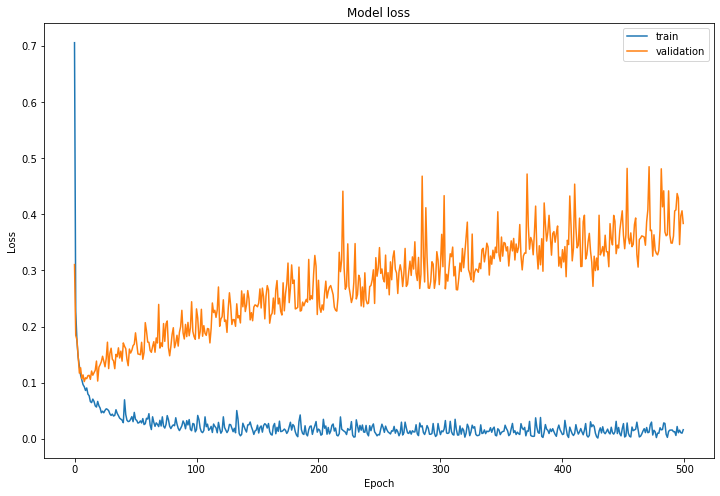

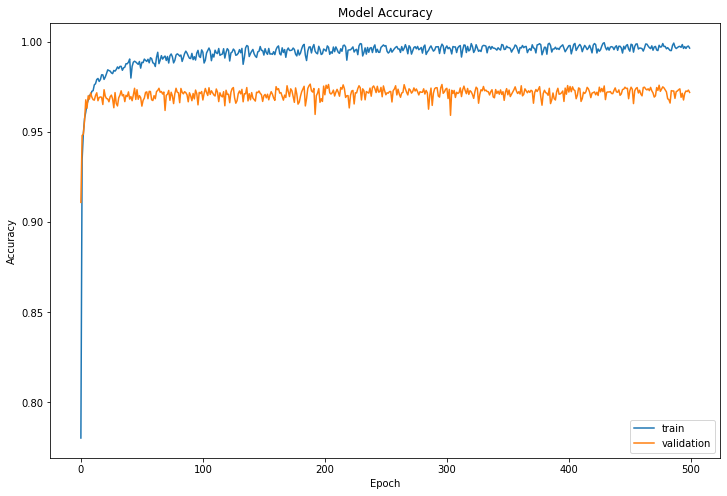

In [24]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

## Test Results

In [21]:
test = pd.read_csv('../data/digit-recognizer/test.csv')

In [22]:
test.shape

(28000, 784)

In [23]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
test = StandardScaler().fit_transform(np.float32(test.values)) # Convert the dataframe to a numpy array
test_data = test.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images


In [25]:
test_data.shape

(28000, 28, 28, 1)

In [74]:
pred = conv_model.predict(test_data)

In [75]:
pred

array([[3.77015036e-04, 1.71635198e-04, 9.99307871e-01, ...,
        6.06279264e-06, 1.08330445e-04, 4.80016126e-07],
       [9.99628425e-01, 2.02510248e-11, 5.12749612e-05, ...,
        7.05237142e-07, 7.17887633e-06, 3.17451025e-08],
       [5.86395359e-08, 1.38420535e-06, 2.45998008e-03, ...,
        2.81476765e-04, 3.34023684e-01, 6.62448108e-01],
       ...,
       [2.07597370e-10, 1.34138345e-05, 3.63944528e-05, ...,
        1.07771775e-05, 1.97790570e-07, 2.20498819e-07],
       [1.21382050e-06, 9.19206627e-07, 8.98009148e-07, ...,
        2.21124297e-04, 2.96301205e-05, 9.60171759e-01],
       [2.37478554e-04, 2.43217692e-05, 9.94917512e-01, ...,
        2.07011821e-04, 3.36308801e-03, 1.37950437e-05]], dtype=float32)

In [27]:
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot, 1)

In [77]:
dense_pred = one_hot_to_dense(pred)

In [78]:
dense_pred

array([2, 0, 9, ..., 3, 9, 2])

## Submission

In [80]:
submission = pd.DataFrame(data={'ImageId':(np.arange(dense_pred.shape[0])+1), 'Label':(dense_pred)})

In [81]:
submission.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [82]:
submission.to_csv('../kaggle_out_data/digit_recog_tf_cnn_sub.csv', index=False)


## LeNet Network

In [17]:
def LeNet_model(input_shape):
    '''
    INP -> CONV -> AvgPool -> CONV -> AvgPool -> FC -> FC -> Softmax
    '''
    input_img = tf.keras.Input(shape = input_shape)
    z1 = tf.keras.layers.Conv2D(6, (5,5), strides=1, padding='same')(input_img)
    A1 = tf.keras.layers.ReLU()(z1)
    P1 = tf.keras.layers.AveragePooling2D(pool_size = (2,2), strides=2)(A1)
    z2 = tf.keras.layers.Conv2D(16, (5,5), strides=1)(P1)
    A2 = tf.keras.layers.ReLU()(z2)
    P2 = tf.keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2)(A2)
    F = tf.keras.layers.Flatten()(P2)
    FC1 = tf.keras.layers.Dense(120, activation='relu')(F)
    FC2 = tf.keras.layers.Dense(84, activation='relu')(FC1)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(FC2)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    return model

In [18]:
lenet_model = LeNet_model((28, 28,1))

In [19]:
lenet_model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

lenet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 6)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 10, 10, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0     

In [19]:
%%time
history_lenet = lenet_model.fit(train_dataset, epochs=500, validation_data=valid_dataset)

Train for 500 steps, validate for 157 steps
Epoch 1/500
500/500 [==============================] - 6s 13ms/step - loss: 0.3161 - accuracy: 0.9043 - val_loss: 0.1028 - val_accuracy: 0.9675
Epoch 2/500
500/500 [==============================] - 6s 12ms/step - loss: 0.0916 - accuracy: 0.9717 - val_loss: 0.0783 - val_accuracy: 0.9746
Epoch 3/500
500/500 [==============================] - 6s 11ms/step - loss: 0.0632 - accuracy: 0.9811 - val_loss: 0.0604 - val_accuracy: 0.9796
Epoch 4/500
500/500 [==============================] - 6s 11ms/step - loss: 0.0477 - accuracy: 0.9859 - val_loss: 0.0622 - val_accuracy: 0.9802
Epoch 5/500
500/500 [==============================] - 6s 12ms/step - loss: 0.0369 - accuracy: 0.9889 - val_loss: 0.0581 - val_accuracy: 0.9809
Epoch 6/500
500/500 [==============================] - 6s 12ms/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 0.0555 - val_accuracy: 0.9839
Epoch 7/500
500/500 [==============================] - 6s 12ms/step - loss: 0.0236 - accurac

Epoch 57/500
500/500 [==============================] - 6s 12ms/step - loss: 8.6165e-07 - accuracy: 1.0000 - val_loss: 0.0897 - val_accuracy: 0.9907
Epoch 58/500
500/500 [==============================] - 6s 12ms/step - loss: 6.6647e-07 - accuracy: 1.0000 - val_loss: 0.0912 - val_accuracy: 0.9907
Epoch 59/500
500/500 [==============================] - 6s 12ms/step - loss: 5.1637e-07 - accuracy: 1.0000 - val_loss: 0.0928 - val_accuracy: 0.9907
Epoch 60/500
500/500 [==============================] - 6s 12ms/step - loss: 4.0222e-07 - accuracy: 1.0000 - val_loss: 0.0944 - val_accuracy: 0.9908
Epoch 61/500
500/500 [==============================] - 6s 12ms/step - loss: 3.1356e-07 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 0.9908
Epoch 62/500
500/500 [==============================] - 6s 13ms/step - loss: 2.4328e-07 - accuracy: 1.0000 - val_loss: 0.0976 - val_accuracy: 0.9909
Epoch 63/500
500/500 [==============================] - 7s 14ms/step - loss: 1.8905e-07 - accuracy: 1.0000

Epoch 112/500
500/500 [==============================] - 6s 13ms/step - loss: 1.4529e-10 - accuracy: 1.0000 - val_loss: 0.1332 - val_accuracy: 0.9906
Epoch 113/500
500/500 [==============================] - 6s 13ms/step - loss: 1.1548e-10 - accuracy: 1.0000 - val_loss: 0.1329 - val_accuracy: 0.9908
Epoch 114/500
500/500 [==============================] - 6s 13ms/step - loss: 1.2293e-10 - accuracy: 1.0000 - val_loss: 0.1329 - val_accuracy: 0.9908
Epoch 115/500
500/500 [==============================] - 7s 13ms/step - loss: 1.1176e-10 - accuracy: 1.0000 - val_loss: 0.1330 - val_accuracy: 0.9908
Epoch 116/500
500/500 [==============================] - 7s 13ms/step - loss: 1.0803e-10 - accuracy: 1.0000 - val_loss: 0.1330 - val_accuracy: 0.9908
Epoch 117/500
500/500 [==============================] - 6s 13ms/step - loss: 8.9407e-11 - accuracy: 1.0000 - val_loss: 0.1329 - val_accuracy: 0.9909
Epoch 118/500
500/500 [==============================] - 6s 12ms/step - loss: 1.1176e-10 - accuracy:

Epoch 221/500
500/500 [==============================] - 6s 13ms/step - loss: 1.8626e-11 - accuracy: 1.0000 - val_loss: 0.2189 - val_accuracy: 0.9899
Epoch 222/500
500/500 [==============================] - 6s 13ms/step - loss: 2.6077e-11 - accuracy: 1.0000 - val_loss: 0.2204 - val_accuracy: 0.9898
Epoch 223/500
500/500 [==============================] - 7s 13ms/step - loss: 2.6077e-11 - accuracy: 1.0000 - val_loss: 0.2221 - val_accuracy: 0.9899
Epoch 224/500
500/500 [==============================] - 7s 13ms/step - loss: 2.2352e-11 - accuracy: 1.0000 - val_loss: 0.2241 - val_accuracy: 0.9897
Epoch 225/500
500/500 [==============================] - 7s 13ms/step - loss: 3.7253e-11 - accuracy: 1.0000 - val_loss: 0.2256 - val_accuracy: 0.9897
Epoch 226/500
500/500 [==============================] - 6s 13ms/step - loss: 4.0978e-11 - accuracy: 1.0000 - val_loss: 0.2270 - val_accuracy: 0.9898
Epoch 227/500
500/500 [==============================] - 6s 13ms/step - loss: 3.3528e-11 - accuracy:

500/500 [==============================] - 6s 13ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0910 - val_accuracy: 0.9899
Epoch 277/500
500/500 [==============================] - 6s 12ms/step - loss: 0.0097 - accuracy: 0.9977 - val_loss: 0.1134 - val_accuracy: 0.9865
Epoch 278/500
500/500 [==============================] - 6s 13ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.1124 - val_accuracy: 0.9880
Epoch 279/500
500/500 [==============================] - 6s 13ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.1040 - val_accuracy: 0.9887
Epoch 280/500
500/500 [==============================] - 6s 13ms/step - loss: 9.3087e-04 - accuracy: 0.9996 - val_loss: 0.1069 - val_accuracy: 0.9890
Epoch 281/500
500/500 [==============================] - 6s 13ms/step - loss: 9.7882e-04 - accuracy: 0.9997 - val_loss: 0.1021 - val_accuracy: 0.9894
Epoch 282/500
500/500 [==============================] - 6s 12ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1102 - val_a

Epoch 331/500
500/500 [==============================] - 7s 13ms/step - loss: 2.9057e-10 - accuracy: 1.0000 - val_loss: 0.1377 - val_accuracy: 0.9902
Epoch 332/500
500/500 [==============================] - 6s 13ms/step - loss: 2.1234e-10 - accuracy: 1.0000 - val_loss: 0.1389 - val_accuracy: 0.9902
Epoch 333/500
500/500 [==============================] - 6s 12ms/step - loss: 1.6391e-10 - accuracy: 1.0000 - val_loss: 0.1401 - val_accuracy: 0.9902
Epoch 334/500
500/500 [==============================] - 6s 12ms/step - loss: 1.3039e-10 - accuracy: 1.0000 - val_loss: 0.1412 - val_accuracy: 0.9902
Epoch 335/500
500/500 [==============================] - 6s 13ms/step - loss: 8.5682e-11 - accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 0.9902
Epoch 336/500
500/500 [==============================] - 6s 13ms/step - loss: 5.5879e-11 - accuracy: 1.0000 - val_loss: 0.1430 - val_accuracy: 0.9902
Epoch 337/500
500/500 [==============================] - 6s 13ms/step - loss: 3.3528e-11 - accuracy:

Epoch 440/500
500/500 [==============================] - 6s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.2153 - val_accuracy: 0.9891
Epoch 441/500
500/500 [==============================] - 6s 13ms/step - loss: 1.1176e-11 - accuracy: 1.0000 - val_loss: 0.2160 - val_accuracy: 0.9892
Epoch 442/500
500/500 [==============================] - 6s 12ms/step - loss: 7.4506e-12 - accuracy: 1.0000 - val_loss: 0.2165 - val_accuracy: 0.9892
Epoch 443/500
500/500 [==============================] - 6s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.2178 - val_accuracy: 0.9891
Epoch 444/500
500/500 [==============================] - 6s 12ms/step - loss: 3.7253e-12 - accuracy: 1.0000 - val_loss: 0.2191 - val_accuracy: 0.9892
Epoch 445/500
500/500 [==============================] - 6s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.2206 - val_accuracy: 0.9893
Epoch 446/500
500/500 [==============================] - 7s 13ms/step - loss: 1.4901e-11 - accuracy:

In [27]:
pred_lenet = lenet_model.predict(test_data)

In [28]:
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot, 1)

In [29]:
dense_pred_lenet = one_hot_to_dense(pred_lenet)

In [30]:
submission_lenet = pd.DataFrame(data={'ImageId':(np.arange(dense_pred_lenet.shape[0])+1), 'Label':(dense_pred_lenet)})

In [32]:
submission_lenet.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [33]:
submission_lenet.to_csv('../kaggle_out_data/digit_recog_tf_lenet.csv', index=False)


## Lenet with Data Augmentation

In [16]:
# Data Augmentation
datagen = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.1)
datagen.fit(train_data)

In [20]:
lenet_model.fit_generator(datagen.flow(train_data, train_labels, batch_size=100), steps_per_epoch=len(train_data)/100, 
                    epochs=100, validation_data=(valid_data, valid_labels))


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 320.0 steps, validate on 10000 samples
Epoch 1/100
320/320 [==============================] - 10s 33ms/step - loss: 0.6954 - accuracy: 0.7795 - val_loss: 0.1500 - val_accuracy: 0.9560
Epoch 2/100
320/320 [==============================] - 13s 39ms/step - loss: 0.2485 - accuracy: 0.9237 - val_loss: 0.1130 - val_accuracy: 0.9651
Epoch 3/100
320/320 [==============================] - 14s 44ms/step - loss: 0.1892 - accuracy: 0.9420 - val_loss: 0.1117 - val_accuracy: 0.9659
Epoch 4/100
320/320 [==============================] - 15s 47ms/step - loss: 0.1615 - accuracy: 0.9519 - val_loss: 0.0733 - val_accuracy: 0.9780
Epoch 5/100
320/320 [==============================] - 14s 43ms/step - loss: 0.1347 - accuracy: 0.9594 - val_loss: 0.0640 - val_accuracy: 0.9816
Epoch 6/100
320/320 [==============================] - 12s 39ms/step - loss: 0.1224 - accuracy: 0.9627 - val_loss: 0.0782 - v

320/320 [==============================] - 13s 39ms/step - loss: 0.0287 - accuracy: 0.9903 - val_loss: 0.0327 - val_accuracy: 0.9915
Epoch 55/100
320/320 [==============================] - 13s 40ms/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 0.0337 - val_accuracy: 0.9918
Epoch 56/100
320/320 [==============================] - 13s 41ms/step - loss: 0.0230 - accuracy: 0.9921 - val_loss: 0.0339 - val_accuracy: 0.9907
Epoch 57/100
320/320 [==============================] - 13s 41ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0358 - val_accuracy: 0.9911
Epoch 58/100
320/320 [==============================] - 12s 38ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0345 - val_accuracy: 0.9912
Epoch 59/100
320/320 [==============================] - 11s 35ms/step - loss: 0.0251 - accuracy: 0.9916 - val_loss: 0.0384 - val_accuracy: 0.9893
Epoch 60/100
320/320 [==============================] - 12s 37ms/step - loss: 0.0265 - accuracy: 0.9911 - val_loss: 0.0406 - val_accuracy

In [26]:
lenet_aug_pred = lenet_model.predict(test_data)


In [28]:
lenet_aug_pred_dense_pred = one_hot_to_dense(lenet_aug_pred)

In [29]:
sub_lenet_aug = pd.DataFrame(data={'ImageId':(np.arange(lenet_aug_pred_dense_pred.shape[0])+1), 
                                   'Label':(lenet_aug_pred_dense_pred)})

In [30]:
sub_lenet_aug.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [31]:
sub_lenet_aug.to_csv('../kaggle_out_data/digit_recog_tf_lenet_augment.csv', index=False)
